# Importing necessary libraries

In [1]:
import os, sys, copy, helper, warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import cv2
import csv


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, utils
from torchvision.utils import make_grid

import imageio
from sklearn.metrics import confusion_matrix
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [2]:
def show_images(dataloader): 
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
        break

def accuracy(output, target):
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim = 1)
    equals = top_class == target.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [3]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [4]:
!nvidia-smi

/bin/bash: /home/sysadm/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jun 26 14:43:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GV100        On   | 00000000:2D:00.0  On |                  Off |
| 30%   43C    P2    25W / 250W |   2241MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--

# Setting necessary paths

In [5]:
path = '/home/sysadm/Documents/3ml_kkm/env/chest_xray'
train_dir = path + '/train'
test_dir = path + '/test'

# Creating dataframe with data stats

In [6]:
n_train = []
n_test = []
classes = ['PNEUMONIA', 'NORMAL']
for c in classes:
    train_images = os.listdir(train_dir + '/' + c)
    n_train.append(len(train_images))
    test_images = os.listdir(test_dir + '/' + c)
    n_test.append(len(test_images))
  

In [7]:
print(n_train)
print(n_test)

[3884, 1349]
[390, 235]


In [8]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0  PNEUMONIA   3884   390
1     NORMAL   1349   235



# Visualising data stats

In [9]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Train')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Training data',fontsize=15);

In [10]:
# plt.figure(figsize=(8,8))
# sns.barplot(data=data, x='Classes', y='Test')
# plt.xlabel('Classes',fontsize=15)
# plt.ylabel('Count',fontsize=15)
# plt.title('Test data',fontsize=15);

# Creating dataframe from images and labels


In [11]:
# train set

ptrain = []
ctrain = []
for folder_name in classes:
    for files in os.listdir(train_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = train_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptrain.append(path)
            ctrain.append(clss)


# test set

ptest = []
ctest = []
for folder_name in classes:
    for files in os.listdir(test_dir + '/' + folder_name):
        if files.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
            path = test_dir + '/' + folder_name + '/' + files
            clss = folder_name
            ptest.append(path)
            ctest.append(clss)

In [12]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head(10)


,Path,Class
0,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
1,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
2,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
3,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
4,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
5,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
6,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
7,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
8,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA
9,/home/sysadm/Documents/3ml_kkm/env/chest_xray/...,PNEUMONIA


# Data to csv

In [13]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

# Defining transformations for data augumentation

In [14]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ]) 

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                      ])

# Creating Custom Dataloader

In [15]:
class PneumoniaDataset():
    def __init__(self,df,labels,transform=True):
        self.df = df
        self.labels=list(df.iloc[:,1])
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.loc[idx]
        img_file, img_class = row['Path'], row['Class']
        img = Image.open(img_file).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img,img_class

In [16]:
class_dict = {'NORMAL':0, 'PNEUMONIA':1}
train_data = PneumoniaDataset(train_df,class_dict,transform = train_transforms)
test_data = PneumoniaDataset(test_df,class_dict,transform = test_transforms)

# verifying the dataloader

print(len(train_data))
next(iter(train_data))

5232


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'PNEUMONIA')

In [17]:
print(len(test_data))
next(iter(test_data))

624


(tensor([[[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          [-0.6863, -0.6863, -0.6941,  ..., -0.6235, -0.6314, -0.6471],
          ...,
          [-0.8196, -0.8275, -0.8275,  ..., -0.8353, -0.8275, -0.8196],
          [-0.3333, -0.8039, -0.8275,  ..., -0.8353, -0.8039, -0.3255],
          [-0.8510, -0.8275, -0.8275,  ..., -0.8353, -0.8353, -0.8510]],
 
         [[-0.6549, -0.6941, -0.6941,  ..., -0.6157, -0.6314, -0.6471],
          [-0.6863, -0.7020,

# Splitting training data into training and validation sets

In [18]:
# training indices to be used for validation
num_train = len(train_data); print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train)); print(split)
train_idx, valid_idx = indices[split:], indices[:split] 

5232
1046


In [19]:
# defining samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [20]:
# loading the data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 30, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 30, shuffle = True)
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
         

# Building the model

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

We have trained this model twice - with 2 different optimisers:


*   Adam
*   SGD with Nesterov accelaration

These are known to produce the best results in image classification problems. The training given below has been done on Adam. To use SGD with Nesterov accelaration instead, use the commented out optimizer instead of the one used below.









In [22]:
# specifying the loss function (categorical cross-entropy)

model = ConvNet()
criterion = nn.CrossEntropyLoss()

# specifying optimizer

optimizer = optim.Adam(model.parameters(), lr = 0.008, weight_decay = 0.02)
# optimizer = optim.SGD(model.parameters(), lr = 0.008,momentum = 0.9, nesterov = True)

# specifying scheduler

scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.2)

if train_on_gpu:
    model.cuda()

print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2)

In [23]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'


# Training and validating the model


In [24]:
# number of epochs to train the model
n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []
for epoch in tqdm(range(1, n_epochs+1), desc = "Train Model/Epoch: "):

    # keeping track of loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_accuracy = 0.0
    valid_accuracy = 0.0

    ######################
    # training the model #
    ######################
    model.train()
    for data, target in tqdm(train_loader, desc = 'Model Train: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clearing the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # performing a single optimization step (parameter update)
        optimizer.step()
        # updating training loss
        train_loss += loss.item()*data.size(0)
        # updating training accuracy
        train_accuracy += accuracy(output,target)
        
    scheduler.step() # decay LR

    ########################  
    # validating the model #
    ########################
    model.eval()
    for data, target in tqdm(valid_loader, desc = 'Model validation: '):
        # moving tensors to GPU if CUDA is available
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        target = target.long()
        # calculating the batch loss
        loss = criterion(output, target)
        # updating average validation loss 
        valid_loss += loss.item()*data.size(0)
        # updating validation accuracy
        valid_accuracy += accuracy(output,target)
    
    # calculating average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # calculating average accuracy
    train_accuracy = train_accuracy/len(train_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
      
    # printing training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n\t\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), './../models/model_pneumonia.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 93.315630 	Validation Loss: 13.231612 
		Training Accuracy: 0.735209 	Validation Accuracy: 0.751355
Validation loss decreased (inf --> 13.231612).  Saving model ...



Epoch: 2 	Training Loss: 11.001721 	Validation Loss: 9.386755 
		Training Accuracy: 0.835626 	Validation Accuracy: 0.843077
Validation loss decreased (13.231612 --> 9.386755).  Saving model ...



Epoch: 3 	Training Loss: 7.608097 	Validation Loss: 5.981129 
		Training Accuracy: 0.897233 	Validation Accuracy: 0.913187
Validation loss decreased (9.386755 --> 5.981129).  Saving model ...



Epoch: 4 	Training Loss: 6.393426 	Validation Loss: 4.494911 
		Training Accuracy: 0.916905 	Validation Accuracy: 0.941612
Validation loss decreased (5.981129 --> 4.494911).  Saving model ...



Epoch: 5 	Training Loss: 5.587666 	Validation Loss: 4.085685 
		Training Accuracy: 0.929524 	Validation Accuracy: 0.947326
Validation loss decreased (4.494911 --> 4.085685).  Saving model ...



Epoch: 6 	Training Loss: 5.231816 	Validation Loss: 4.170011 
		Training Accuracy: 0.939584 	Validation Accuracy: 0.951428



Epoch: 7 	Training Loss: 5.377116 	Validation Loss: 4.073543 
		Training Accuracy: 0.930715 	Validation Accuracy: 0.950476
Validation loss decreased (4.085685 --> 4.073543).  Saving model ...



Epoch: 8 	Training Loss: 5.403007 	Validation Loss: 4.092332 
		Training Accuracy: 0.932858 	Validation Accuracy: 0.946374



Epoch: 9 	Training Loss: 5.327699 	Validation Loss: 4.085027 
		Training Accuracy: 0.936429 	Validation Accuracy: 0.949231



Epoch: 10 	Training Loss: 5.282424 	Validation Loss: 4.183171 
		Training Accuracy: 0.940953 	Validation Accuracy: 0.951429



Epoch: 11 	Training Loss: 5.264866 	Validation Loss: 4.018157 
		Training Accuracy: 0.934554 	Validation Accuracy: 0.951648
Validation loss decreased (4.073543 --> 4.018157).  Saving model ...



Epoch: 12 	Training Loss: 5.357390 	Validation Loss: 4.009534 
		Training Accuracy: 0.935953 	Validation Accuracy: 0.949524
Validation loss decreased (4.018157 --> 4.009534).  Saving model ...



Epoch: 13 	Training Loss: 5.283020 	Validation Loss: 4.241716 
		Training Accuracy: 0.935983 	Validation Accuracy: 0.949377



Epoch: 14 	Training Loss: 5.180368 	Validation Loss: 4.164049 
		Training Accuracy: 0.938125 	Validation Accuracy: 0.952088



Epoch: 15 	Training Loss: 5.319301 	Validation Loss: 4.268825 
		Training Accuracy: 0.935477 	Validation Accuracy: 0.942711



Epoch: 16 	Training Loss: 5.494116 	Validation Loss: 4.084896 
		Training Accuracy: 0.931727 	Validation Accuracy: 0.956190



Epoch: 17 	Training Loss: 5.347593 	Validation Loss: 4.108602 
		Training Accuracy: 0.940000 	Validation Accuracy: 0.952894



Epoch: 18 	Training Loss: 5.385566 	Validation Loss: 4.138858 
		Training Accuracy: 0.937620 	Validation Accuracy: 0.951282



Epoch: 19 	Training Loss: 5.414881 	Validation Loss: 4.249811 
		Training Accuracy: 0.930060 	Validation Accuracy: 0.949231



Epoch: 20 	Training Loss: 5.171977 	Validation Loss: 4.103261 
		Training Accuracy: 0.938334 	Validation Accuracy: 0.956996



Epoch: 21 	Training Loss: 5.231961 	Validation Loss: 4.138890 
		Training Accuracy: 0.938334 	Validation Accuracy: 0.946520



Epoch: 22 	Training Loss: 5.306494 	Validation Loss: 4.209517 
		Training Accuracy: 0.933899 	Validation Accuracy: 0.947473



Epoch: 23 	Training Loss: 5.344278 	Validation Loss: 4.098197 
		Training Accuracy: 0.933840 	Validation Accuracy: 0.952234



Epoch: 24 	Training Loss: 5.349139 	Validation Loss: 4.156520 
		Training Accuracy: 0.933155 	Validation Accuracy: 0.952381



Epoch: 25 	Training Loss: 5.252996 	Validation Loss: 4.097153 
		Training Accuracy: 0.939108 	Validation Accuracy: 0.946520



Epoch: 26 	Training Loss: 5.224114 	Validation Loss: 3.880306 
		Training Accuracy: 0.935715 	Validation Accuracy: 0.956850
Validation loss decreased (4.009534 --> 3.880306).  Saving model ...



Epoch: 27 	Training Loss: 5.418578 	Validation Loss: 4.030985 
		Training Accuracy: 0.935030 	Validation Accuracy: 0.949377



Epoch: 28 	Training Loss: 5.380930 	Validation Loss: 4.169838 
		Training Accuracy: 0.933096 	Validation Accuracy: 0.947473



Epoch: 29 	Training Loss: 5.291454 	Validation Loss: 4.122813 
		Training Accuracy: 0.937143 	Validation Accuracy: 0.951135



Epoch: 30 	Training Loss: 5.414609 	Validation Loss: 4.152105 
		Training Accuracy: 0.933363 	Validation Accuracy: 0.950989



Epoch: 31 	Training Loss: 5.599827 	Validation Loss: 4.397212 
		Training Accuracy: 0.932917 	Validation Accuracy: 0.944176



Epoch: 32 	Training Loss: 5.306814 	Validation Loss: 4.127370 
		Training Accuracy: 0.937143 	Validation Accuracy: 0.948425



Epoch: 33 	Training Loss: 5.332738 	Validation Loss: 4.007503 
		Training Accuracy: 0.936191 	Validation Accuracy: 0.953187



Epoch: 34 	Training Loss: 5.305545 	Validation Loss: 4.165992 
		Training Accuracy: 0.934792 	Validation Accuracy: 0.945714



Epoch: 35 	Training Loss: 5.387228 	Validation Loss: 4.187372 
		Training Accuracy: 0.931727 	Validation Accuracy: 0.947326



Epoch: 36 	Training Loss: 5.447307 	Validation Loss: 4.081319 
		Training Accuracy: 0.932382 	Validation Accuracy: 0.951135



Epoch: 37 	Training Loss: 5.403985 	Validation Loss: 4.018902 
		Training Accuracy: 0.934822 	Validation Accuracy: 0.955897



Epoch: 38 	Training Loss: 5.231502 	Validation Loss: 4.234011 
		Training Accuracy: 0.937679 	Validation Accuracy: 0.947473



Epoch: 39 	Training Loss: 5.540439 	Validation Loss: 4.095484 
		Training Accuracy: 0.934554 	Validation Accuracy: 0.954139



Epoch: 40 	Training Loss: 5.255801 	Validation Loss: 4.033912 
		Training Accuracy: 0.935477 	Validation Accuracy: 0.951135



Epoch: 41 	Training Loss: 5.481751 	Validation Loss: 4.075156 
		Training Accuracy: 0.933631 	Validation Accuracy: 0.952234



Epoch: 42 	Training Loss: 5.391012 	Validation Loss: 4.088616 
		Training Accuracy: 0.938602 	Validation Accuracy: 0.951941



Epoch: 43 	Training Loss: 5.378264 	Validation Loss: 4.107519 
		Training Accuracy: 0.933125 	Validation Accuracy: 0.951282



Epoch: 44 	Training Loss: 5.366748 	Validation Loss: 4.245088 
		Training Accuracy: 0.939078 	Validation Accuracy: 0.947619



Epoch: 45 	Training Loss: 5.266440 	Validation Loss: 4.330565 
		Training Accuracy: 0.933155 	Validation Accuracy: 0.945714



Epoch: 46 	Training Loss: 5.297874 	Validation Loss: 4.167210 
		Training Accuracy: 0.930774 	Validation Accuracy: 0.951282



Epoch: 47 	Training Loss: 5.291521 	Validation Loss: 4.200123 
		Training Accuracy: 0.941994 	Validation Accuracy: 0.951941



Epoch: 48 	Training Loss: 5.315259 	Validation Loss: 4.011314 
		Training Accuracy: 0.936429 	Validation Accuracy: 0.958095



Epoch: 49 	Training Loss: 5.383057 	Validation Loss: 4.100624 
		Training Accuracy: 0.933602 	Validation Accuracy: 0.952381



Epoch: 50 	Training Loss: 5.243314 	Validation Loss: 4.201158 
		Training Accuracy: 0.938572 	Validation Accuracy: 0.952235



Epoch: 51 	Training Loss: 5.548219 	Validation Loss: 4.204676 
		Training Accuracy: 0.929108 	Validation Accuracy: 0.953187



Epoch: 52 	Training Loss: 5.477765 	Validation Loss: 4.154686 
		Training Accuracy: 0.933840 	Validation Accuracy: 0.953187



Epoch: 53 	Training Loss: 5.432943 	Validation Loss: 4.185037 
		Training Accuracy: 0.933810 	Validation Accuracy: 0.949084



Epoch: 54 	Training Loss: 5.429778 	Validation Loss: 4.039366 
		Training Accuracy: 0.932649 	Validation Accuracy: 0.953187



Epoch: 55 	Training Loss: 5.315614 	Validation Loss: 4.192927 
		Training Accuracy: 0.933125 	Validation Accuracy: 0.947472



Epoch: 56 	Training Loss: 5.243185 	Validation Loss: 4.193239 
		Training Accuracy: 0.934286 	Validation Accuracy: 0.947179



Epoch: 57 	Training Loss: 5.247080 	Validation Loss: 4.071528 
		Training Accuracy: 0.932649 	Validation Accuracy: 0.951135



Epoch: 58 	Training Loss: 5.482343 	Validation Loss: 4.095442 
		Training Accuracy: 0.931251 	Validation Accuracy: 0.949377



Epoch: 59 	Training Loss: 5.307808 	Validation Loss: 4.138032 
		Training Accuracy: 0.935477 	Validation Accuracy: 0.952381



Epoch: 60 	Training Loss: 5.246701 	Validation Loss: 4.006477 
		Training Accuracy: 0.940983 	Validation Accuracy: 0.953333



Epoch: 61 	Training Loss: 5.252184 	Validation Loss: 4.139248 
		Training Accuracy: 0.934524 	Validation Accuracy: 0.954139



Epoch: 62 	Training Loss: 5.254468 	Validation Loss: 4.152190 
		Training Accuracy: 0.935060 	Validation Accuracy: 0.949084



Epoch: 63 	Training Loss: 5.377372 	Validation Loss: 4.102465 
		Training Accuracy: 0.934286 	Validation Accuracy: 0.950183



Epoch: 64 	Training Loss: 5.209690 	Validation Loss: 4.029185 
		Training Accuracy: 0.933334 	Validation Accuracy: 0.952381



Epoch: 65 	Training Loss: 5.284525 	Validation Loss: 4.234337 
		Training Accuracy: 0.935268 	Validation Accuracy: 0.948278



Epoch: 66 	Training Loss: 5.267018 	Validation Loss: 4.277296 
		Training Accuracy: 0.933840 	Validation Accuracy: 0.950476



Epoch: 67 	Training Loss: 5.365191 	Validation Loss: 3.952138 
		Training Accuracy: 0.934346 	Validation Accuracy: 0.954945



Epoch: 68 	Training Loss: 5.225647 	Validation Loss: 4.195219 
		Training Accuracy: 0.936756 	Validation Accuracy: 0.951282



Epoch: 69 	Training Loss: 5.400603 	Validation Loss: 4.108695 
		Training Accuracy: 0.936429 	Validation Accuracy: 0.946080



Epoch: 70 	Training Loss: 5.353506 	Validation Loss: 4.019142 
		Training Accuracy: 0.936935 	Validation Accuracy: 0.954945



Epoch: 71 	Training Loss: 5.395344 	Validation Loss: 4.096796 
		Training Accuracy: 0.931459 	Validation Accuracy: 0.954139



Epoch: 72 	Training Loss: 5.357442 	Validation Loss: 4.007990 
		Training Accuracy: 0.932649 	Validation Accuracy: 0.951428



Epoch: 73 	Training Loss: 5.242542 	Validation Loss: 4.161111 
		Training Accuracy: 0.935804 	Validation Accuracy: 0.956996



Epoch: 74 	Training Loss: 5.292256 	Validation Loss: 4.217030 
		Training Accuracy: 0.939762 	Validation Accuracy: 0.949377



Epoch: 75 	Training Loss: 5.447322 	Validation Loss: 4.062519 
		Training Accuracy: 0.933602 	Validation Accuracy: 0.952381



Epoch: 76 	Training Loss: 5.451521 	Validation Loss: 3.924657 
		Training Accuracy: 0.932411 	Validation Accuracy: 0.952088



Epoch: 77 	Training Loss: 5.284238 	Validation Loss: 4.127369 
		Training Accuracy: 0.936935 	Validation Accuracy: 0.949524



Epoch: 78 	Training Loss: 5.253035 	Validation Loss: 4.085200 
		Training Accuracy: 0.935536 	Validation Accuracy: 0.953553



Epoch: 79 	Training Loss: 5.525156 	Validation Loss: 4.138450 
		Training Accuracy: 0.934524 	Validation Accuracy: 0.946227



Epoch: 80 	Training Loss: 5.369488 	Validation Loss: 4.144981 
		Training Accuracy: 0.934822 	Validation Accuracy: 0.947985



Epoch: 81 	Training Loss: 5.361708 	Validation Loss: 4.002879 
		Training Accuracy: 0.935000 	Validation Accuracy: 0.952088



Epoch: 82 	Training Loss: 5.347869 	Validation Loss: 3.990900 
		Training Accuracy: 0.931667 	Validation Accuracy: 0.950330



Epoch: 83 	Training Loss: 5.356505 	Validation Loss: 4.011973 
		Training Accuracy: 0.936697 	Validation Accuracy: 0.946520



Epoch: 84 	Training Loss: 5.470829 	Validation Loss: 4.341613 
		Training Accuracy: 0.936459 	Validation Accuracy: 0.942418



Epoch: 85 	Training Loss: 5.288324 	Validation Loss: 4.381775 
		Training Accuracy: 0.935269 	Validation Accuracy: 0.945421



Epoch: 86 	Training Loss: 5.545764 	Validation Loss: 4.322989 
		Training Accuracy: 0.935030 	Validation Accuracy: 0.943663



Epoch: 87 	Training Loss: 5.363979 	Validation Loss: 4.138115 
		Training Accuracy: 0.934316 	Validation Accuracy: 0.951941



Epoch: 88 	Training Loss: 5.405092 	Validation Loss: 4.323427 
		Training Accuracy: 0.934524 	Validation Accuracy: 0.947619



Epoch: 89 	Training Loss: 5.242276 	Validation Loss: 4.201240 
		Training Accuracy: 0.937411 	Validation Accuracy: 0.942711



Epoch: 90 	Training Loss: 5.335229 	Validation Loss: 4.148859 
		Training Accuracy: 0.935715 	Validation Accuracy: 0.953040



Epoch: 91 	Training Loss: 5.222869 	Validation Loss: 4.339113 
		Training Accuracy: 0.931786 	Validation Accuracy: 0.947473



Epoch: 92 	Training Loss: 5.235520 	Validation Loss: 4.196450 
		Training Accuracy: 0.936489 	Validation Accuracy: 0.949230



Epoch: 93 	Training Loss: 5.296696 	Validation Loss: 4.308913 
		Training Accuracy: 0.934286 	Validation Accuracy: 0.951282



Epoch: 94 	Training Loss: 5.386463 	Validation Loss: 4.070652 
		Training Accuracy: 0.932679 	Validation Accuracy: 0.950476



Epoch: 95 	Training Loss: 5.399301 	Validation Loss: 4.155322 
		Training Accuracy: 0.934554 	Validation Accuracy: 0.953187



Epoch: 96 	Training Loss: 5.516370 	Validation Loss: 4.143037 
		Training Accuracy: 0.930715 	Validation Accuracy: 0.951429



Epoch: 97 	Training Loss: 5.432114 	Validation Loss: 4.037500 
		Training Accuracy: 0.932471 	Validation Accuracy: 0.951135



Epoch: 98 	Training Loss: 5.060012 	Validation Loss: 4.002109 
		Training Accuracy: 0.936965 	Validation Accuracy: 0.950330



Epoch: 99 	Training Loss: 5.172154 	Validation Loss: 4.071762 
		Training Accuracy: 0.937620 	Validation Accuracy: 0.952235



Epoch: 100 	Training Loss: 5.273653 	Validation Loss: 4.138175 
		Training Accuracy: 0.940060 	Validation Accuracy: 0.951282



In [25]:
print('Total pretrained parameters: ', sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total trainable parameter: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total pretrained parameters:  0
Total trainable parameter:  17697666


# Plotting training/validation losses

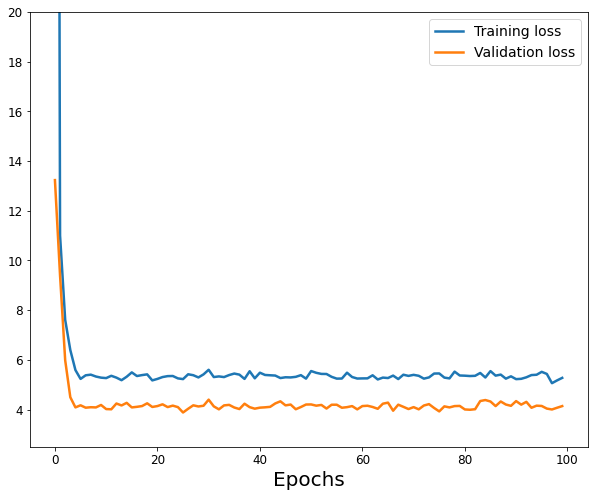

In [26]:

plt.figure(figsize=(10,8))
plt.plot(train_losses,'-',linewidth = 2.5, label='Training loss')
plt.plot(valid_losses,'-', linewidth = 2.5, label='Validation loss')
plt.xlabel('Epochs',fontsize = 20)
plt.ylim(2.5,20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Plotting training/validation accuracy

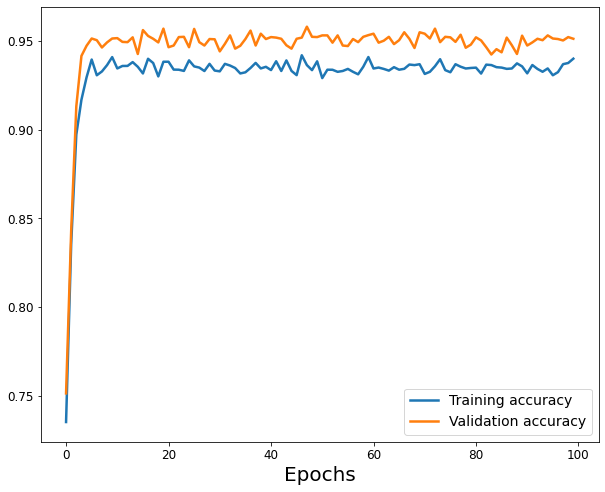

In [27]:
plt.figure(figsize=(10,8))
plt.plot(train_acc,'-', linewidth = 2.5, label='Training accuracy')
plt.plot(valid_acc,'-', linewidth = 2.5, label='Validation accuracy')
plt.xlabel('Epochs', fontsize = 20)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

# Loading model with lowest validation loss

In [28]:
pwd

'/home/sysadm/Documents/3ml_kkm/env'

In [29]:
model.load_state_dict(torch.load('./../models/model_pneumonia.pt'))

<All keys matched successfully>

# Testing the model

In [30]:
# tracking test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterating over test data
for data, target in tqdm(test_loader, desc = 'Model Test: '):
    # moving tensors to GPU if CUDA is available
    data = torch.Tensor(data)
    target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
    target = torch.Tensor(np.array(target))
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: computing predicted outputs by passing inputs to the model
    output = model(data)
    target = target.long()
    # calculating the batch loss
    loss = criterion(output, target)
    # updating test loss 
    test_loss += loss.item()*data.size(0)
    # converting output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # comparing predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculating test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.502247

Test Accuracy of PNEUMONIA: 51% (121/234)
Test Accuracy of NORMAL: 96% (375/390)

Test Accuracy (Overall): 79% (496/624)


In [43]:
print('Minimum training loss', np.min(train_losses))
print('Minimum validation loss', valid_loss_min)
print('Test loss', test_loss)
print('Maximum training accuracy', np.max(train_acc))
print('Maximum validation accuracy', np.min(valid_acc))
print('Test accuracy for NORMAL class', '51%')
print('Test accuracy for PNEUMONIA class', '96%')
print('Overall test accuracy', '79%')

Minimum training loss 5.0600122154291185
Minimum validation loss 3.8803062983921595
Test loss 0.502246575573316
Maximum training accuracy 0.94199437
Maximum validation accuracy 0.75135535
Test accuracy for NORMAL class 51%
Test accuracy for PNEUMONIA class 96%
Overall test accuracy 79%


In [41]:
np.max(train_acc)

0.94199437

# Evaulating the model

In [31]:
confusion_matrix = torch.zeros(2,2)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = torch.Tensor(data)
        target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])
        target = torch.Tensor(np.array(target))
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            target = target.long()
            _, preds = torch.max(output, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[121., 113.],
        [ 15., 375.]])


In [32]:
cm = confusion_matrix.numpy()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)
print("Precision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}".format(precision,recall,f1_score))

Precision: 0.7684
Recall: 0.9615
F1 Score: 0.8542


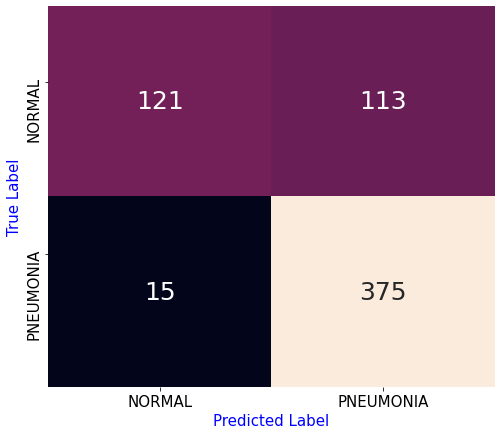

In [35]:
plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 25})
xticks = np.array(['NORMAL','PNEUMONIA'])
sns.heatmap(cm, annot = True, fmt=".0f", cbar = False)
plt.xticks([0.5,1.5], xticks, fontsize = 15); plt.yticks([0.4,1.3], xticks, fontsize = 15)
plt.xlabel('Predicted Label', fontsize = 15, color = 'b')
plt.ylabel('True Label', fontsize = 15, color = 'b');

# Visualising predicted results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


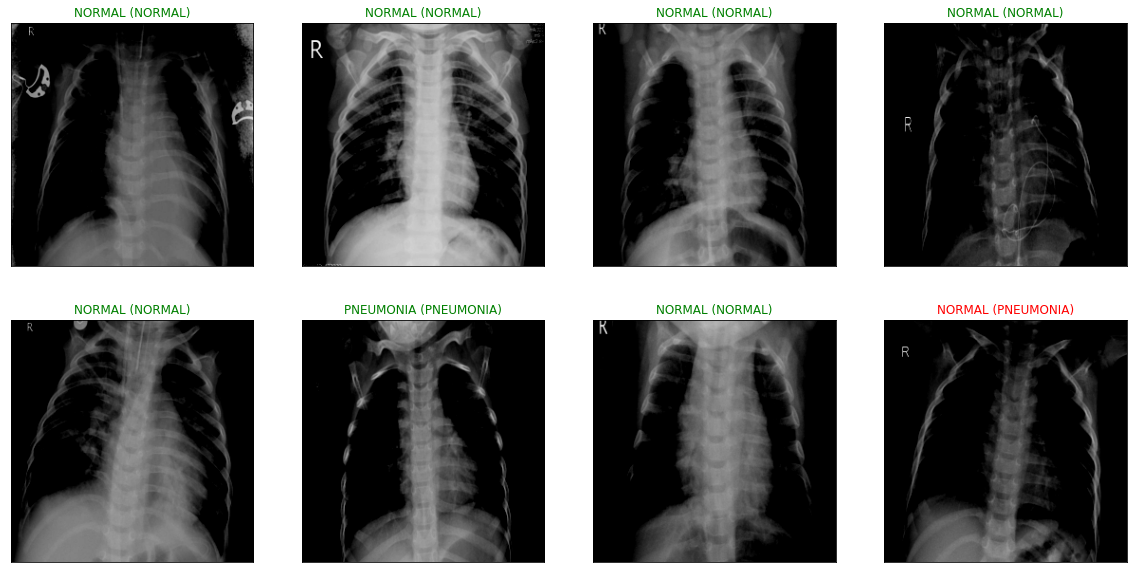

In [34]:
# obtaining one batch of test images
data, target = next(iter(test_loader))
data.numpy()

# moving model inputs to cuda, if GPU available
if train_on_gpu:
    data = data.cuda()

# getting sample outputs
output = model(data)

# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
target = tuple([0 if i=='NORMAL' else 1 for i in list(target)])

# plotting the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20,10))
for idx in np.arange(8):
    ax = fig.add_subplot(2,4, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].permute(1, 2, 0) if not train_on_gpu else data[idx].cpu().permute(1, 2, 0))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx] else "red"))